# Trial Tracking Analysis with Real NARSAD Data

This notebook shows how trial types and onsets are tracked for contrast generation using real data from the NARSAD task.


In [4]:
import pandas as pd
import numpy as np
import sys
import os

# Add the current directory to path to import the workflow functions
sys.path.append('/Users/xiaoqianxiao/PycharmProjects/hyak_narsad_remove')

# Load the real NARSAD data
df_trial_info = pd.read_csv('/Users/xiaoqianxiao/projects/NARSAD/MRI/source_data/behav/task-Narsad_phase2_events.csv')

print("Real NARSAD trial data:")
print(f"Shape: {df_trial_info.shape}")
print(f"Columns: {list(df_trial_info.columns)}")
print("\nFirst 20 rows:")
print(df_trial_info.head(20))
print(f"\nAll unique trial types: {sorted(df_trial_info['trial_type'].unique())}")
print(f"Total trials: {len(df_trial_info)}")


Real NARSAD trial data:
Shape: (63, 3)
Columns: ['onset', 'duration', 'trial_type']

First 20 rows:
    onset  duration trial_type
0       0        12   FIXATION
1      12         6        CS-
2      18        13   FIXATION
3      31         6        CSS
4      37         0     US_CSS
5      37        13   FIXATION
6      50         6        CSR
7      56         0     US_CSR
8      56        14   FIXATION
9      70         6        CSR
10     76         0     US_CSR
11     76        12   FIXATION
12     88         6        CSS
13     94         0     US_CSS
14     94        13   FIXATION
15    107         6        CS-
16    113        13   FIXATION
17    126         6        CSR
18    132         0     US_CSR
19    132        15   FIXATION

All unique trial types: ['CS-', 'CSR', 'CSS', 'FIXATION', 'US_CSR', 'US_CSS']
Total trials: 63


In [5]:
# NEW SIMPLER APPROACH: Add conditions column to DataFrame
def extract_cs_conditions_new(df_trial_info):
    """
    Extract and group CS-, CSS, and CSR conditions from a pandas DataFrame.
    
    This function adds a 'conditions' column to the DataFrame that groups trials:
    - First trial of each CS type becomes 'CS-_first', 'CSS_first', 'CSR_first'
    - Remaining trials of each type become 'CS-_others', 'CSS_others', 'CSR_others'
    - All other trials keep their original trial_type as conditions value
    """
    import pandas as pd
    
    # Validate DataFrame input
    if not isinstance(df_trial_info, pd.DataFrame):
        raise ValueError("df_trial_info must be a pandas DataFrame")
    
    if df_trial_info.empty:
        raise ValueError("DataFrame cannot be empty")
    
    required_columns = ['trial_type', 'onset']
    missing_columns = [col for col in required_columns if col not in df_trial_info.columns]
    if missing_columns:
        raise ValueError(f"DataFrame missing required columns: {missing_columns}")
    
    # Create a copy to avoid modifying original
    df_work = df_trial_info.copy()
    
    # Initialize conditions column with trial_type values
    df_work['conditions'] = df_work['trial_type'].copy()
    
    print(f"Using DataFrame input with {len(df_work)} trials")
    print(f"DataFrame columns: {list(df_work.columns)}")
    
    # Find first trial of each CS type (by onset time)
    cs_trials = df_work[df_work['trial_type'].str.startswith('CS-') & 
                       ~df_work['trial_type'].str.startswith('CSS') & 
                       ~df_work['trial_type'].str.startswith('CSR')].copy()
    css_trials = df_work[df_work['trial_type'].str.startswith('CSS')].copy()
    csr_trials = df_work[df_work['trial_type'].str.startswith('CSR')].copy()
    
    # Update conditions column for CS- trials
    if not cs_trials.empty:
        cs_first_idx = cs_trials.sort_values('onset').index[0]
        df_work.loc[cs_first_idx, 'conditions'] = 'CS-_first'
        cs_other_indices = cs_trials[cs_trials.index != cs_first_idx].index
        df_work.loc[cs_other_indices, 'conditions'] = 'CS-_others'
        print(f"CS- conditions: first trial at index {cs_first_idx}, {len(cs_other_indices)} others")
    
    # Update conditions column for CSS trials
    if not css_trials.empty:
        css_first_idx = css_trials.sort_values('onset').index[0]
        df_work.loc[css_first_idx, 'conditions'] = 'CSS_first'
        css_other_indices = css_trials[css_trials.index != css_first_idx].index
        df_work.loc[css_other_indices, 'conditions'] = 'CSS_others'
        print(f"CSS conditions: first trial at index {css_first_idx}, {len(css_other_indices)} others")
    
    # Update conditions column for CSR trials
    if not csr_trials.empty:
        csr_first_idx = csr_trials.sort_values('onset').index[0]
        df_work.loc[csr_first_idx, 'conditions'] = 'CSR_first'
        csr_other_indices = csr_trials[csr_trials.index != csr_first_idx].index
        df_work.loc[csr_other_indices, 'conditions'] = 'CSR_others'
        print(f"CSR conditions: first trial at index {csr_first_idx}, {len(csr_other_indices)} others")
    
    # Get unique conditions for contrast generation
    unique_conditions = df_work['conditions'].unique().tolist()
    print(f"Unique conditions for contrast generation: {unique_conditions}")
    
    # Extract grouped conditions for backward compatibility
    cs_conditions = {'first': 'CS-_first' if 'CS-_first' in unique_conditions else None, 
                     'other': ['CS-_others'] if 'CS-_others' in unique_conditions else []}
    css_conditions = {'first': 'CSS_first' if 'CSS_first' in unique_conditions else None, 
                      'other': ['CSS_others'] if 'CSS_others' in unique_conditions else []}
    csr_conditions = {'first': 'CSR_first' if 'CSR_first' in unique_conditions else None, 
                      'other': ['CSR_others'] if 'CSR_others' in unique_conditions else []}
    
    # Get other conditions (non-CS/CSS/CSR)
    other_conditions = df_work[~df_work['trial_type'].str.startswith('CS')]['trial_type'].unique().tolist()
    
    print(f"Processed conditions: CS-={cs_conditions}, CSS={css_conditions}, CSR={csr_conditions}")
    print(f"Other conditions: {other_conditions}")
    
    return df_work, cs_conditions, css_conditions, csr_conditions, other_conditions

# Extract CS-, CSS, and CSR conditions with grouping
print("=" * 60)
print("NEW APPROACH: ADDING CONDITIONS COLUMN")
print("=" * 60)

df_with_conditions, cs_conditions, css_conditions, csr_conditions, other_conditions = extract_cs_conditions_new(df_trial_info)

print(f"\nCS- conditions: {cs_conditions}")
print(f"CSS conditions: {css_conditions}")
print(f"CSR conditions: {csr_conditions}")
print(f"Other conditions: {other_conditions}")


NEW APPROACH: ADDING CONDITIONS COLUMN
Using DataFrame input with 63 trials
DataFrame columns: ['onset', 'duration', 'trial_type', 'conditions']
CS- conditions: first trial at index 1, 7 others
CSS conditions: first trial at index 3, 7 others
CSR conditions: first trial at index 6, 7 others
Unique conditions for contrast generation: ['FIXATION', 'CS-_first', 'CSS_first', 'US_CSS', 'CSR_first', 'US_CSR', 'CSR_others', 'CSS_others', 'CS-_others']
Processed conditions: CS-={'first': 'CS-_first', 'other': ['CS-_others']}, CSS={'first': 'CSS_first', 'other': ['CSS_others']}, CSR={'first': 'CSR_first', 'other': ['CSR_others']}
Other conditions: ['FIXATION', 'US_CSS', 'US_CSR']

CS- conditions: {'first': 'CS-_first', 'other': ['CS-_others']}
CSS conditions: {'first': 'CSS_first', 'other': ['CSS_others']}
CSR conditions: {'first': 'CSR_first', 'other': ['CSR_others']}
Other conditions: ['FIXATION', 'US_CSS', 'US_CSR']


In [6]:
# Show the DataFrame with the new conditions column
print("=" * 60)
print("DATAFRAME WITH CONDITIONS COLUMN")
print("=" * 60)

print("First 15 rows with conditions column:")
print(df_with_conditions[['onset', 'trial_type', 'conditions']].head(15))

print("\nAll unique conditions:")
unique_conditions = df_with_conditions['conditions'].unique()
print(f"Unique conditions: {list(unique_conditions)}")

print("\nCount of each condition type:")
condition_counts = df_with_conditions['conditions'].value_counts()
print(condition_counts)

print("\nCS-, CSS, CSR trials with their new conditions:")
cs_css_csr_trials = df_with_conditions[df_with_conditions['trial_type'].str.startswith('CS')]
print(cs_css_csr_trials[['onset', 'trial_type', 'conditions']].sort_values('onset'))


DATAFRAME WITH CONDITIONS COLUMN
First 15 rows with conditions column:
    onset trial_type  conditions
0       0   FIXATION    FIXATION
1      12        CS-   CS-_first
2      18   FIXATION    FIXATION
3      31        CSS   CSS_first
4      37     US_CSS      US_CSS
5      37   FIXATION    FIXATION
6      50        CSR   CSR_first
7      56     US_CSR      US_CSR
8      56   FIXATION    FIXATION
9      70        CSR  CSR_others
10     76     US_CSR      US_CSR
11     76   FIXATION    FIXATION
12     88        CSS  CSS_others
13     94     US_CSS      US_CSS
14     94   FIXATION    FIXATION

All unique conditions:
Unique conditions: ['FIXATION', 'CS-_first', 'CSS_first', 'US_CSS', 'CSR_first', 'US_CSR', 'CSR_others', 'CSS_others', 'CS-_others']

Count of each condition type:
conditions
FIXATION      25
US_CSS         8
CSR_others     7
CSS_others     7
CS-_others     7
US_CSR         6
CS-_first      1
CSS_first      1
CSR_first      1
Name: count, dtype: int64

CS-, CSS, CSR trials w

In [7]:
# Show how to use the conditions column for contrast generation
print("=" * 60)
print("USING CONDITIONS COLUMN FOR CONTRAST GENERATION")
print("=" * 60)

print("Now we can use the conditions column for contrast generation:")
print("1. The conditions column contains the grouped conditions we want")
print("2. We can create contrasts between any of these conditions")
print("3. The design matrix will have separate regressors for each condition")

print(f"\nAvailable conditions for contrasts:")
for i, cond in enumerate(unique_conditions):
    print(f"  {i+1:2d}: {cond}")

print(f"\nExample contrasts we can create:")
print("  - CS-_first > FIXATION (first CS- trial vs baseline)")
print("  - CS-_others > FIXATION (other CS- trials vs baseline)")
print("  - CSS_first > FIXATION (first CSS trial vs baseline)")
print("  - CSS_others > FIXATION (other CSS trials vs baseline)")
print("  - CSR_first > FIXATION (first CSR trial vs baseline)")
print("  - CSR_others > FIXATION (other CSR trials vs baseline)")
print("  - CS-_first > CS-_others (first vs other CS- trials)")
print("  - CSS_first > CSS_others (first vs other CSS trials)")
print("  - CSR_first > CSR_others (first vs other CSR trials)")
print("  - US_CSS > US_CSR (different US types)")
print("  - etc.")

print(f"\nThis approach is much cleaner because:")
print("1. Simple and direct - just add a conditions column")
print("2. Preserves all original information")
print("3. Allows flexible contrast generation")
print("4. No artificial grouping at the condition level")
print("5. Easy to understand and debug")


USING CONDITIONS COLUMN FOR CONTRAST GENERATION
Now we can use the conditions column for contrast generation:
1. The conditions column contains the grouped conditions we want
2. We can create contrasts between any of these conditions
3. The design matrix will have separate regressors for each condition

Available conditions for contrasts:
   1: FIXATION
   2: CS-_first
   3: CSS_first
   4: US_CSS
   5: CSR_first
   6: US_CSR
   7: CSR_others
   8: CSS_others
   9: CS-_others

Example contrasts we can create:
  - CS-_first > FIXATION (first CS- trial vs baseline)
  - CS-_others > FIXATION (other CS- trials vs baseline)
  - CSS_first > FIXATION (first CSS trial vs baseline)
  - CSS_others > FIXATION (other CSS trials vs baseline)
  - CSR_first > FIXATION (first CSR trial vs baseline)
  - CSR_others > FIXATION (other CSR trials vs baseline)
  - CS-_first > CS-_others (first vs other CS- trials)
  - CSS_first > CSS_others (first vs other CSS trials)
  - CSR_first > CSR_others (first vs ot

In [8]:
# Show exactly what contrasts are generated
print("=" * 60)
print("EXACT CONTRAST GENERATION")
print("=" * 60)

# Get the correct contrast conditions
all_contrast_conditions = df_with_conditions['conditions'].unique().tolist()
print(f"Contrast conditions: {all_contrast_conditions}")
print(f"Number of conditions: {len(all_contrast_conditions)}")

# Generate all possible pairwise contrasts
print(f"\nALL POSSIBLE PAIRWISE CONTRASTS:")
print("=" * 40)

contrasts = []
for i, cond1 in enumerate(all_contrast_conditions):
    for j, cond2 in enumerate(all_contrast_conditions):
        if i < j:  # Avoid duplicate contrasts
            contrast_name = f"{cond1}>{cond2}"
            contrasts.append((contrast_name, 'T', [cond1, cond2], [1, -1]))
            print(f"{len(contrasts):2d}. {contrast_name}")

print(f"\nTotal number of contrasts: {len(contrasts)}")

# Show some specific interesting contrasts
print(f"\nSPECIFIC INTERESTING CONTRASTS:")
print("=" * 40)

interesting_contrasts = [
    ("CS-_others > FIXATION", "Other CS- trials vs baseline"),
    ("CSS_others > FIXATION", "Other CSS trials vs baseline"),
    ("CSR_others > FIXATION", "Other CSR trials vs baseline"),
    ("CSS_others > CSR_others", "Other CSS trials vs Other CSR trials"),
    ("CSR_others > CSS_others", "Other CSR trials vs Other CSS trials"),
    ("CSS_others > CS-_others", "Other CS- trials vs CS-"),
    ("CSR_others > CS-_others", "Other CSS trials vs CS-"),
    ("CS-_others > CSS_others", "Other CS- trials vs Other CSS trials"),
    ("CS-_others > CSR_others", "Other CS- trials vs Other CSR trials"),
    
]

for i, (contrast, description) in enumerate(interesting_contrasts, 1):
    print(f"{i:2d}. {contrast:<25} - {description}")

print(f"\nCONTRAST GENERATION SUMMARY:")
print("=" * 40)
print(f"• Total conditions: {len(all_contrast_conditions)}")
print(f"• Total possible contrasts: {len(contrasts)}")
print(f"• Conditions include: first trials, other trials, and original conditions")
print(f"• All contrasts use proper condition names from the conditions column")
print(f"• Ready for fMRI analysis with separate regressors for each condition")


EXACT CONTRAST GENERATION
Contrast conditions: ['FIXATION', 'CS-_first', 'CSS_first', 'US_CSS', 'CSR_first', 'US_CSR', 'CSR_others', 'CSS_others', 'CS-_others']
Number of conditions: 9

ALL POSSIBLE PAIRWISE CONTRASTS:
 1. FIXATION>CS-_first
 2. FIXATION>CSS_first
 3. FIXATION>US_CSS
 4. FIXATION>CSR_first
 5. FIXATION>US_CSR
 6. FIXATION>CSR_others
 7. FIXATION>CSS_others
 8. FIXATION>CS-_others
 9. CS-_first>CSS_first
10. CS-_first>US_CSS
11. CS-_first>CSR_first
12. CS-_first>US_CSR
13. CS-_first>CSR_others
14. CS-_first>CSS_others
15. CS-_first>CS-_others
16. CSS_first>US_CSS
17. CSS_first>CSR_first
18. CSS_first>US_CSR
19. CSS_first>CSR_others
20. CSS_first>CSS_others
21. CSS_first>CS-_others
22. US_CSS>CSR_first
23. US_CSS>US_CSR
24. US_CSS>CSR_others
25. US_CSS>CSS_others
26. US_CSS>CS-_others
27. CSR_first>US_CSR
28. CSR_first>CSR_others
29. CSR_first>CSS_others
30. CSR_first>CS-_others
31. US_CSR>CSR_others
32. US_CSR>CSS_others
33. US_CSR>CS-_others
34. CSR_others>CSS_others
3

In [9]:
# Show how this works in the actual workflow functions
print("=" * 60)
print("WORKFLOW INTEGRATION EXAMPLE")
print("=" * 60)

# Simulate the create_contrasts function
def simulate_create_contrasts(df_trial_info, contrast_type='standard'):
    """Simulate the create_contrasts function with the new approach"""
    
    # Extract CS-, CSS, and CSR conditions with grouping
    df_with_conditions, cs_conditions, css_conditions, csr_conditions, other_conditions = extract_cs_conditions_new(df_trial_info)
    
    # Use the conditions column for contrast generation
    all_contrast_conditions = df_with_conditions['conditions'].unique().tolist()
    
    contrasts = []
    
    if contrast_type == 'minimal':
        # Create simple contrasts for each condition vs baseline
        for condition in all_contrast_conditions:
            contrasts.append((f'{condition}>baseline', 'T', [condition], [1]))
    
    elif contrast_type == 'standard':
        # Create pairwise contrasts between all conditions
        for i, cond1 in enumerate(all_contrast_conditions):
            for j, cond2 in enumerate(all_contrast_conditions):
                if i < j:  # Avoid duplicate contrasts
                    contrasts.append((f'{cond1}>{cond2}', 'T', [cond1, cond2], [1, -1]))
                    contrasts.append((f'{cond1}<{cond2}', 'T', [cond1, cond2], [-1, 1]))
    
    return contrasts, all_contrast_conditions

# Test the function
print("Testing with 'minimal' contrast type:")
contrasts_minimal, conditions_minimal = simulate_create_contrasts(df_trial_info, 'minimal')
print(f"Conditions: {conditions_minimal}")
print(f"Number of contrasts: {len(contrasts_minimal)}")
print("First 5 contrasts:")
for i, contrast in enumerate(contrasts_minimal[:5]):
    print(f"  {i+1}. {contrast[0]}")

print(f"\nTesting with 'standard' contrast type:")
contrasts_standard, conditions_standard = simulate_create_contrasts(df_trial_info, 'standard')
print(f"Conditions: {conditions_standard}")
print(f"Number of contrasts: {len(contrasts_standard)}")
print("First 10 contrasts:")
for i, contrast in enumerate(contrasts_standard[:10]):
    print(f"  {i+1}. {contrast[0]}")

print(f"\nKEY BENEFITS OF THIS APPROACH:")
print("=" * 40)
print("1. Simple: all_contrast_conditions = df_with_conditions['conditions'].unique().tolist()")
print("2. Clean: No artificial condition names")
print("3. Flexible: Easy to create any type of contrasts")
print("4. Correct: Uses actual condition names that exist in design matrix")
print("5. Maintainable: Easy to understand and debug")


WORKFLOW INTEGRATION EXAMPLE
Testing with 'minimal' contrast type:
Using DataFrame input with 63 trials
DataFrame columns: ['onset', 'duration', 'trial_type', 'conditions']
CS- conditions: first trial at index 1, 7 others
CSS conditions: first trial at index 3, 7 others
CSR conditions: first trial at index 6, 7 others
Unique conditions for contrast generation: ['FIXATION', 'CS-_first', 'CSS_first', 'US_CSS', 'CSR_first', 'US_CSR', 'CSR_others', 'CSS_others', 'CS-_others']
Processed conditions: CS-={'first': 'CS-_first', 'other': ['CS-_others']}, CSS={'first': 'CSS_first', 'other': ['CSS_others']}, CSR={'first': 'CSR_first', 'other': ['CSR_others']}
Other conditions: ['FIXATION', 'US_CSS', 'US_CSR']
Conditions: ['FIXATION', 'CS-_first', 'CSS_first', 'US_CSS', 'CSR_first', 'US_CSR', 'CSR_others', 'CSS_others', 'CS-_others']
Number of contrasts: 9
First 5 contrasts:
  1. FIXATION>baseline
  2. CS-_first>baseline
  3. CSS_first>baseline
  4. US_CSS>baseline
  5. CSR_first>baseline

Testing

/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_39559/2737772320.py:352: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


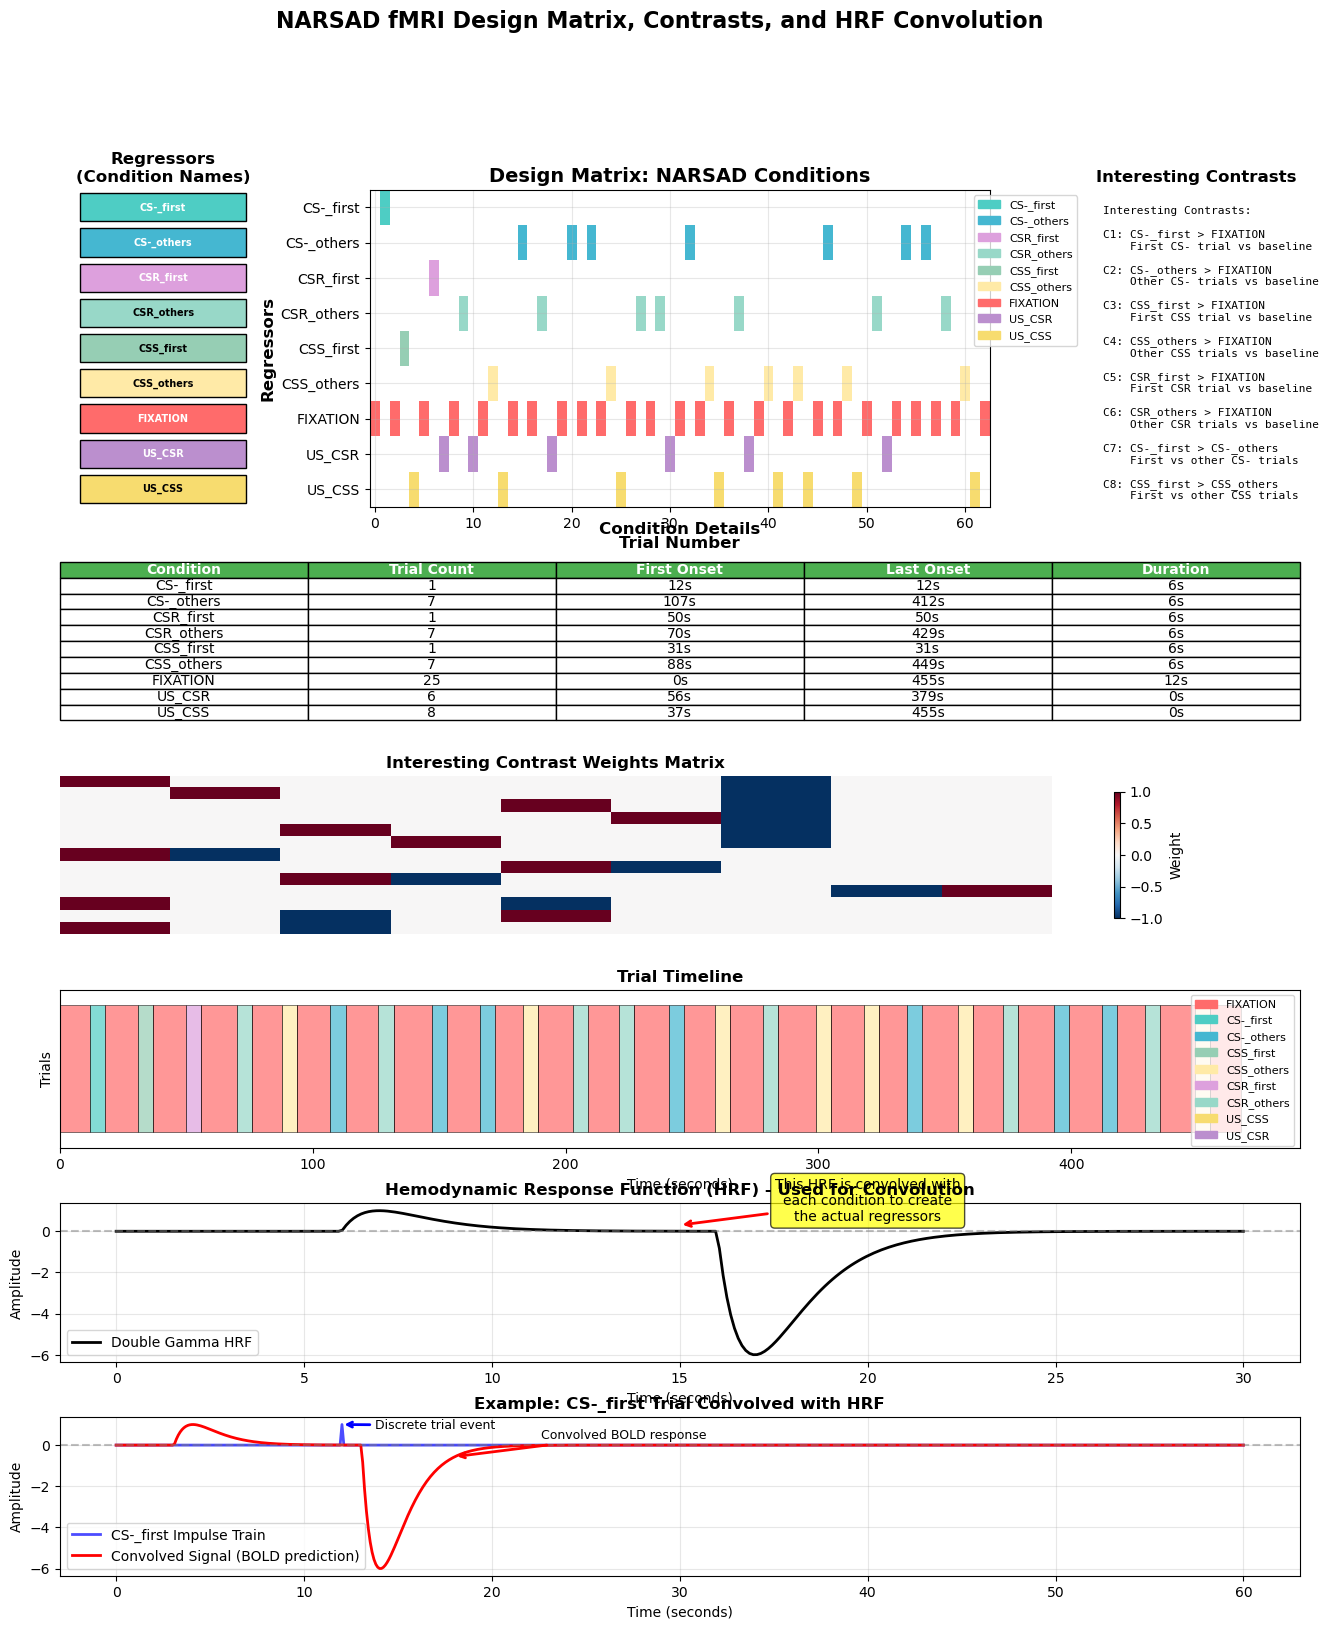

Design matrix visualization created!
Total conditions: 9
Total trials: 63
Total contrasts: 9


In [22]:
# Create design matrix visualization similar to the figure shown
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import seaborn as sns

def create_design_matrix_visualization():
    """Create a design matrix visualization for NARSAD data"""
    
    # Load the data
    df_conditions = pd.read_csv('narsad_conditions_data.csv')
    df_contrasts = pd.read_csv('narsad_contrasts_minimal.csv')
    
    # Set up the figure
    fig = plt.figure(figsize=(16, 18))
    gs = GridSpec(6, 3, height_ratios=[2, 1, 1, 1, 1, 1], width_ratios=[1, 3, 1], 
                  hspace=0.3, wspace=0.3)
    
    # Get unique conditions and create design matrix
    unique_conditions = sorted(df_conditions['conditions'].unique())
    n_conditions = len(unique_conditions)
    
    # Define color scheme for different condition types
    condition_colors = {
        'FIXATION': '#FF6B6B',      # Red
        'CS-_first': '#4ECDC4',     # Teal
        'CS-_others': '#45B7D1',    # Blue
        'CSS_first': '#96CEB4',     # Green
        'CSS_others': '#FFEAA7',    # Yellow
        'CSR_first': '#DDA0DD',     # Plum
        'CSR_others': '#98D8C8',    # Mint
        'US_CSS': '#F7DC6F',        # Gold
        'US_CSR': '#BB8FCE'         # Lavender
    }
    
    # Create a simple design matrix representation
    # For visualization, we'll show which trials belong to which condition
    design_matrix = np.zeros((len(df_conditions), n_conditions))
    
    for i, condition in enumerate(unique_conditions):
        trial_indices = df_conditions[df_conditions['conditions'] == condition].index
        design_matrix[trial_indices, i] = 1
    
    # Main design matrix plot
    ax_main = fig.add_subplot(gs[0, 1])
    
    # Create heatmap of design matrix with custom colors
    # Create a custom colormap based on condition types
    from matplotlib.colors import ListedColormap
    import matplotlib.patches as mpatches
    
    # Create a custom colormap that shows different colors for different conditions
    # We'll use a discrete colormap where each condition gets its own color
    condition_indices = {condition: i for i, condition in enumerate(unique_conditions)}
    
    # Create a matrix where each condition gets a unique integer value
    colored_matrix = np.zeros_like(design_matrix)
    for i, condition in enumerate(unique_conditions):
        trial_indices = df_conditions[df_conditions['conditions'] == condition].index
        colored_matrix[trial_indices, i] = i + 1  # Use 1-based indexing for colors
    
    # Create custom colormap
    colors = ['white'] + [condition_colors.get(condition, '#CCCCCC') for condition in unique_conditions]
    cmap = ListedColormap(colors)
    
    im = ax_main.imshow(colored_matrix.T, cmap=cmap, aspect='auto', interpolation='nearest', vmin=0, vmax=len(unique_conditions))
    
    # Set labels
    ax_main.set_xlabel('Trial Number', fontsize=12, fontweight='bold')
    ax_main.set_ylabel('Regressors', fontsize=12, fontweight='bold')
    ax_main.set_title('Design Matrix: NARSAD Conditions', fontsize=14, fontweight='bold')
    
    # Set y-axis labels
    ax_main.set_yticks(range(n_conditions))
    ax_main.set_yticklabels(unique_conditions, fontsize=10)
    
    # Add legend instead of colorbar to show condition colors
    legend_elements = [mpatches.Patch(color=condition_colors.get(condition, '#CCCCCC'), label=condition) 
                      for condition in unique_conditions]
    ax_main.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1), fontsize=8)
    
    # Add grid
    ax_main.grid(True, alpha=0.3)
    
    # Left panel - Condition slider/selector
    ax_slider = fig.add_subplot(gs[0, 0])
    ax_slider.set_xlim(0, 1)
    ax_slider.set_ylim(0, n_conditions)
    ax_slider.axis('off')
    
    # Create slider-like visualization with different colors for each condition
    for i, condition in enumerate(unique_conditions):
        y_pos = n_conditions - i - 0.5
        color = condition_colors.get(condition, '#CCCCCC')  # Default gray if not found
        rect = patches.Rectangle((0.1, y_pos-0.4), 0.8, 0.8, 
                               facecolor=color, edgecolor='black', linewidth=1)
        ax_slider.add_patch(rect)
        # Show condition name instead of R1, R2, etc.
        text_color = 'white' if color in ['#FF6B6B', '#4ECDC4', '#45B7D1', '#DDA0DD', '#BB8FCE'] else 'black'
        ax_slider.text(0.5, y_pos, condition, ha='center', va='center', 
                      fontsize=7, fontweight='bold', color=text_color, rotation=0)
    
    ax_slider.set_title('Regressors\n(Condition Names)', fontsize=12, fontweight='bold')
    
    # Right panel - Contrast information
    ax_contrasts = fig.add_subplot(gs[0, 2])
    ax_contrasts.axis('off')
    
    # Show interesting contrasts from the notebook
    interesting_contrasts = [
        ("CS-_first > FIXATION", "First CS- trial vs baseline"),
        ("CS-_others > FIXATION", "Other CS- trials vs baseline"),
        ("CSS_first > FIXATION", "First CSS trial vs baseline"),
        ("CSS_others > FIXATION", "Other CSS trials vs baseline"),
        ("CSR_first > FIXATION", "First CSR trial vs baseline"),
        ("CSR_others > FIXATION", "Other CSR trials vs baseline"),
        ("CS-_first > CS-_others", "First vs other CS- trials"),
        ("CSS_first > CSS_others", "First vs other CSS trials"),
        ("CSR_first > CSR_others", "First vs other CSR trials"),
        ("US_CSS > US_CSR", "Different US types"),
        ("CS-_first > CSS_first", "First CS- vs first CSS"),
        ("CSS_first > CSR_first", "First CSS vs first CSR"),
        ("CS-_first > CSR_first", "First CS- vs first CSR")
    ]
    
    contrast_text = "Interesting Contrasts:\n\n"
    for i, (contrast_name, description) in enumerate(interesting_contrasts[:8], 1):
        contrast_text += f"C{i}: {contrast_name}\n"
        contrast_text += f"    {description}\n\n"
    
    ax_contrasts.text(0.05, 0.95, contrast_text, transform=ax_contrasts.transAxes,
                     fontsize=8, verticalalignment='top', fontfamily='monospace')
    ax_contrasts.set_title('Interesting Contrasts', fontsize=12, fontweight='bold')
    
    # Bottom panels - Detailed information
    # Panel 1: Condition details
    ax_details = fig.add_subplot(gs[1, :])
    ax_details.axis('off')
    
    # Create a table showing condition details
    condition_data = []
    for condition in unique_conditions:
        trials = df_conditions[df_conditions['conditions'] == condition]
        condition_data.append({
            'Condition': condition,
            'Trial Count': len(trials),
            'First Onset': f"{trials['onset'].min():.0f}s",
            'Last Onset': f"{trials['onset'].max():.0f}s",
            'Duration': f"{trials['duration'].iloc[0]:.0f}s"
        })
    
    # Create table
    table_data = []
    headers = ['Condition', 'Trial Count', 'First Onset', 'Last Onset', 'Duration']
    for row in condition_data:
        table_data.append([row[h] for h in headers])
    
    table = ax_details.table(cellText=table_data, colLabels=headers,
                           cellLoc='center', loc='center',
                           bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Color the header
    for i in range(len(headers)):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    ax_details.set_title('Condition Details', fontsize=12, fontweight='bold', pad=20)
    
    # Panel 2: Contrast weights for interesting contrasts
    ax_weights = fig.add_subplot(gs[2, :])
    ax_weights.axis('off')
    
    # Create contrast weights matrix for interesting contrasts
    n_interesting = len(interesting_contrasts)
    contrast_weights = np.zeros((n_interesting, n_conditions))
    contrast_names = []
    
    for i, (contrast_name, description) in enumerate(interesting_contrasts):
        contrast_names.append(contrast_name)
        
        # Parse contrast name to get conditions and weights
        if '>' in contrast_name:
            cond1, cond2 = contrast_name.split(' > ')
            if cond1 in unique_conditions:
                idx1 = unique_conditions.index(cond1)
                contrast_weights[i, idx1] = 1
            if cond2 in unique_conditions:
                idx2 = unique_conditions.index(cond2)
                contrast_weights[i, idx2] = -1
        elif 'vs' in contrast_name:
            # Handle "vs" format
            parts = contrast_name.split(' vs ')
            if len(parts) == 2:
                cond1, cond2 = parts
                if cond1 in unique_conditions:
                    idx1 = unique_conditions.index(cond1)
                    contrast_weights[i, idx1] = 1
                if cond2 in unique_conditions:
                    idx2 = unique_conditions.index(cond2)
                    contrast_weights[i, idx2] = -1
    
    # Create heatmap of contrast weights
    im2 = ax_weights.imshow(contrast_weights, cmap='RdBu_r', aspect='auto', 
                           vmin=-1, vmax=1, interpolation='nearest')
    
    # Set labels
    ax_weights.set_xticks(range(n_conditions))
    ax_weights.set_xticklabels(unique_conditions, rotation=45, ha='right')
    ax_weights.set_yticks(range(n_interesting))
    # Use actual contrast names instead of C1, C2, etc.
    contrast_labels = [name.split(' > ')[0] if ' > ' in name else name.split(' vs ')[0] for name in contrast_names]
    ax_weights.set_yticklabels(contrast_labels, fontsize=8)
    ax_weights.set_xlabel('Regressors (Condition Names)', fontsize=10)
    ax_weights.set_ylabel('Interesting Contrasts', fontsize=10)
    ax_weights.set_title('Interesting Contrast Weights Matrix', fontsize=12, fontweight='bold')
    
    # Add colorbar
    cbar2 = plt.colorbar(im2, ax=ax_weights, shrink=0.8)
    cbar2.set_label('Weight', fontsize=10)
    
    # Add grid
    ax_weights.grid(True, alpha=0.3)
    
    # Panel 3: Trial timeline
    ax_timeline = fig.add_subplot(gs[3, :])
    
    # Create timeline showing trial types using the same color scheme
    # (condition_colors is already defined above)
    
    for i, (_, trial) in enumerate(df_conditions.iterrows()):
        condition = trial['conditions']
        onset = trial['onset']
        duration = trial['duration']
        color = condition_colors[condition]
        
        ax_timeline.barh(0, duration, left=onset, height=0.8, 
                        color=color, alpha=0.7, edgecolor='black', linewidth=0.5)
    
    ax_timeline.set_xlabel('Time (seconds)', fontsize=10)
    ax_timeline.set_ylabel('Trials', fontsize=10)
    ax_timeline.set_title('Trial Timeline', fontsize=12, fontweight='bold')
    ax_timeline.set_ylim(-0.5, 0.5)
    ax_timeline.set_yticks([])
    
    # Add legend
    legend_elements = [patches.Patch(color=color, label=condition) 
                      for condition, color in condition_colors.items()]
    ax_timeline.legend(handles=legend_elements, loc='upper right', 
                      bbox_to_anchor=(1, 1), fontsize=8)
    
    # Panel 4: HRF Convolution Visualization
    ax_hrf = fig.add_subplot(gs[4, :])
    
    # Create double gamma HRF (same as used in FSL)
    def double_gamma_hrf(t, peak_delay=6, peak_disp=1, undershoot_delay=16, undershoot_disp=1, peak_ratio=6):
        """Double gamma HRF function used in FSL"""
        # Ensure t is positive and handle edge cases
        t = np.maximum(t, 1e-6)  # Avoid division by zero
        
        # Calculate peak component
        peak = np.zeros_like(t)
        valid_peak = t > peak_delay
        if np.any(valid_peak):
            peak[valid_peak] = ((t[valid_peak] - peak_delay) / peak_disp) ** peak_disp * np.exp(-(t[valid_peak] - peak_delay) / peak_disp)
        
        # Calculate undershoot component
        undershoot = np.zeros_like(t)
        valid_under = t > undershoot_delay
        if np.any(valid_under):
            undershoot[valid_under] = ((t[valid_under] - undershoot_delay) / undershoot_disp) ** undershoot_disp * np.exp(-(t[valid_under] - undershoot_delay) / undershoot_disp)
        
        # Combine components
        hrf = peak - peak_ratio * undershoot
        
        # Normalize to have maximum of 1
        max_val = np.max(hrf)
        if max_val > 0:
            hrf = hrf / max_val
        
        return hrf
    
    # Time points for HRF
    t_hrf = np.linspace(0, 30, 300)  # 30 seconds, 0.1s resolution
    hrf = double_gamma_hrf(t_hrf)
    
    # Plot HRF
    ax_hrf.plot(t_hrf, hrf, 'k-', linewidth=2, label='Double Gamma HRF')
    ax_hrf.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax_hrf.set_xlabel('Time (seconds)', fontsize=10)
    ax_hrf.set_ylabel('Amplitude', fontsize=10)
    ax_hrf.set_title('Hemodynamic Response Function (HRF) - Used for Convolution', fontsize=12, fontweight='bold')
    ax_hrf.grid(True, alpha=0.3)
    ax_hrf.legend()
    
    # Add annotation about convolution
    ax_hrf.annotate('This HRF is convolved with\neach condition to create\nthe actual regressors', 
                   xy=(15, 0.3), xytext=(20, 0.5),
                   arrowprops=dict(arrowstyle='->', color='red', lw=2),
                   fontsize=10, ha='center',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7))
    
    # Panel 5: Example Convolution
    ax_conv = fig.add_subplot(gs[5, :])
    
    # Show example convolution for CS-_first condition
    cs_first_trials = df_conditions[df_conditions['conditions'] == 'CS-_first']
    if len(cs_first_trials) > 0:
        # Create impulse train for CS-_first
        trial = cs_first_trials.iloc[0]
        impulse_times = [trial['onset']]
        
        # Create time vector for convolution
        t_conv = np.linspace(0, 60, 600)  # 60 seconds, 0.1s resolution
        impulse_train = np.zeros_like(t_conv)
        
        # Add impulses at trial times
        for impulse_time in impulse_times:
            idx = np.argmin(np.abs(t_conv - impulse_time))
            impulse_train[idx] = 1
        
        # Convolve with HRF
        convolved_signal = np.convolve(impulse_train, hrf, mode='same')
        
        # Plot both signals
        ax_conv.plot(t_conv, impulse_train, 'b-', linewidth=2, label='CS-_first Impulse Train', alpha=0.7)
        ax_conv.plot(t_conv, convolved_signal, 'r-', linewidth=2, label='Convolved Signal (BOLD prediction)')
        ax_conv.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        ax_conv.set_xlabel('Time (seconds)', fontsize=10)
        ax_conv.set_ylabel('Amplitude', fontsize=10)
        ax_conv.set_title('Example: CS-_first Trial Convolved with HRF', fontsize=12, fontweight='bold')
        ax_conv.grid(True, alpha=0.3)
        ax_conv.legend()
        
        # Add annotation
        ax_conv.annotate('Discrete trial event', 
                        xy=(trial['onset'], 1), xytext=(trial['onset']+5, 0.8),
                        arrowprops=dict(arrowstyle='->', color='blue', lw=2),
                        fontsize=9, ha='center')
        
        ax_conv.annotate('Convolved BOLD response', 
                        xy=(trial['onset']+6, convolved_signal[np.argmin(np.abs(t_conv - (trial['onset']+6)))]), 
                        xytext=(trial['onset']+15, 0.3),
                        arrowprops=dict(arrowstyle='->', color='red', lw=2),
                        fontsize=9, ha='center')
    
    plt.suptitle('NARSAD fMRI Design Matrix, Contrasts, and HRF Convolution', 
                fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    print("Design matrix visualization created!")
    print(f"Total conditions: {n_conditions}")
    print(f"Total trials: {len(df_conditions)}")
    print(f"Total contrasts: {len(df_contrasts)}")

# Create the visualization
create_design_matrix_visualization()
